In [1]:
import os

import numpy as np
import psutil
import qml


In [2]:
names = np.load("names.npy")
representations = np.load("repr.npy")

In [3]:
len(names)

116687

In [4]:
import itertools as itl
def get_slatm_mbtypes(nuclear_charges, pbc='000'):
    """
    Get the list of minimal types of many-body terms in a dataset. This resulting list
    is necessary as input in the ``generate_slatm_representation()`` function.

    :param nuclear_charges: A list of the nuclear charges for each compound in the dataset.
    :type nuclear_charges: list of numpy arrays
    :param pbc: periodic boundary condition along x,y,z direction, defaulted to '000', i.e., molecule
    :type pbc: string
    :return: A list containing the types of many-body terms.
    :rtype: list
    """

    zs = nuclear_charges

    nm = len(zs)
    zsmax = set()
    nas = []
    zs_ravel = []
    for zsi in zs:
        na = len(zsi); nas.append(na)
        zsil = list(zsi); zs_ravel += zsil
        zsmax.update( zsil )

    zsmax = np.array( list(zsmax) )
    nass = []
    for i in range(nm):
        zsi = np.array(zs[i],np.int16)
        nass.append( [ (zi == zsi).sum() for zi in zsmax ] )

    nzmax = np.max(np.array(nass), axis=0)
    nzmax_u = []
    if pbc != '000':
        # the PBC will introduce new many-body terms, so set
        # nzmax to 3 if it's less than 3
        for nzi in nzmax:
            if nzi <= 2:
                nzi = 3
            nzmax_u.append(nzi)
        nzmax = nzmax_u

    boas = [ [zi,] for zi in zsmax ]
    bops = [ [zi,zi] for zi in zsmax ] + [list(x) for x in list(itl.combinations([1,2,3],2))]

    bots = []
    for i in zsmax:
        for bop in bops:
            j,k = bop
            tas = [ [i,j,k], [i,k,j], [j,i,k] ]
            for tasi in tas:
                if (tasi not in bots) and (tasi[::-1] not in bots):
                    nzsi = [ (zj == tasi).sum() for zj in zsmax ]
                    if np.all(nzsi <= nzmax):
                        bots.append( tasi )
    mbtypes = boas + bops + bots

    return mbtypes #, np.array(zs_ravel), np.array(nas)

In [5]:

here = "/media/mohammed/Work/FORMED_ML/XYZ_FORMED"
namelist = []
for name in os.listdir(
    here
):  # names contains the path to the xyz files to be loaded as compounds which will then be slatmized
    namelist.append(qml.Compound(xyz=str(here +"/" + name)))

compounds = np.asarray(namelist, dtype=object)  # WARNING: REMOVE SLICING
print("Generated compounds; RAM memory % used:", psutil.virtual_memory()[2], flush=True)
print("Total RAM:", psutil.virtual_memory()[0], flush=True)
print("Available RAM:", psutil.virtual_memory()[1], flush=True)




Generated compounds; RAM memory % used: 79.4
Total RAM: 33472344064
Available RAM: 6909763584


In [6]:
mbtypes = get_slatm_mbtypes([mol.nuclear_charges for mol in compounds])

# replace this number with the size of the mbtypes
SIZEOFSLATM = len(mbtypes)
X = np.zeros((len(compounds), SIZEOFSLATM), dtype=np.float16)
N = []
print(
    "Generated empty representation matrix; RAM memory % used:",
    psutil.virtual_memory()[2],
    flush=True,
)

Generated empty representation matrix; RAM memory % used: 79.3


In [7]:
SIZEOFSLATM = 17941

print(
    "Generated empty representation matrix; RAM memory % used:",
    psutil.virtual_memory()[2],
    flush=True,
)

Generated empty representation matrix; RAM memory % used: 79.3


In [8]:
len(mbtypes)

469

In [12]:
N = []
X = np.zeros((len(compounds), SIZEOFSLATM), dtype=np.float16)
N = []
for i, mol in enumerate(compounds):
    print(f"Tackling representation of {namelist[i]}", flush=True)
    mol.generate_slatm(mbtypes, local=False, dgrids=[0.1, 0.1])
    print(mol.representation.shape)
    X[i, :] = np.float16(mol.representation)
    N.append(mol.name)
    break


N = np.array(N)
#np.save("names.npy", N)

Tackling representation of <qml.compound.Compound object at 0x7c6f17510f70>
(17941,)


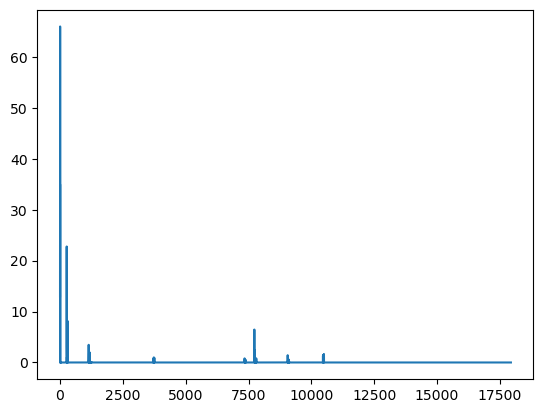

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(X[0])
plt.show()